# Dictionary Counting Script

- Authors: Brian Lei, Jaren Haber
- Institution: University of California, Berkeley
- Date created: Spring 2018
- Date last modified: September 24, 2019
- Description: Finds the number of occurences of a dictionary phrase in the webtext of a school. Creates column for number of webtext words, ratio of hits, and hit strength(log of ratio). Has multiprocessing built in.

## Import packages

In [1]:
import pandas as pd
import re
import numpy as np
import time
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import multiprocessing as mp

# For loading functions from files in data_tools directory:
import sys; sys.path.insert(0, "../../data_management/tools/")

In [2]:
# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

# For calculating densities, years opened and closed, and school closure rates:
from df_calc import count_pdfs, density_calc, openclose_calc, closerate_calc

## Load data

In [3]:
charter_path = '../../misc_data/charters_2015.pkl'
df_charter1 = load_filtered_df(charter_path, ["WEBTEXT", "NCESSCH"])
df_charter1['WEBTEXT']=df_charter1['WEBTEXT'].fillna('') # turn nan to empty iterable for future convenience

stemmer = PorterStemmer()
stem = stemmer.stem # stemmer function

# rows and cols:  (10965, 2)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
WEBTEXT


In [4]:
df_charter1

,NCESSCH,WEBTEXT
0,1.001970e+10,"[(http://www.maef.net/, False, 0, Evening Acad..."
1,2.000010e+10,
2,2.001500e+10,"[(https://www.kgbsd.org/ketchikancharter, Fals..."
3,2.001500e+10,[(http://tongassschool.org/classrooms/3rd-and-...
4,2.001800e+10,"[(https://www.asdk12.org/aquarian, False, 0, S..."
...,...,...
10960,7.200030e+11,
10961,7.200030e+11,
10962,7.200030e+11,
10963,7.200030e+11,


## Define functions for counting dictionaries

In [5]:
def load_dict(dictpath, dictnames, fileext):
    """Loads dictionaries into list.
    Completes dictionary to include entries with slashes ("/"), dashes ("-"), and underscores ("_") taken out.
    
    Args: 
    dictpath: path to folder containing dictionaries
    dictnames: dictionary filenames (without extensions)
    fileext: file extension for all files (must all be the same)
    
    Returns:
    dict_list: List of lists, where each list contains all terms for a dictionary with AND without punctuation
    """
    
    dict_list = []
    for name in dictnames:
        with open(dictpath+name+fileext) as f: 
            new_dict = f.read().splitlines()
            new_words = []
            for entry in new_dict:
                new_words.append(re.sub(' +|/+|-+|_+', '', entry))
            new_dict.extend(new_words)
            new_dict = set(new_dict)
            dict_list.append(list(new_dict))
    return dict_list

In [6]:
dict_path = '/home/jovyan/work/text_analysis/dictionary_methods/dicts/'
dict_names = ['inquiry30', 'discipline30'] # enter list of names of txt files holding dict
file_ext = '.txt'

dict_list = load_dict(dict_path, dict_names, file_ext)
dict_list

[['handsonmindson',
  'experiential',
  'experientially',
  'constructivism',
  'handsonandmindson',
  'active_inquiry',
  'socraticdialogue',
  'learnercentered',
  'project-based',
  'hands-on',
  'experiential_approach',
  'hands-on_and_minds-on',
  'socratic',
  'socraticmethod',
  'student-centered_inquiry-based',
  'studentdrivenexploration',
  'childcentered',
  'hands-on/minds-on',
  'explorationandexperimentation',
  'inquirydriven',
  'activeinquiry',
  'child-centered',
  'inquirybased',
  'discovery-based',
  'socratic_dialogue',
  'studentcenteredinquirybased',
  'exploration_and_experimentation',
  'handsonlearning',
  'learn-by-doing',
  'laboratory-based',
  'projectcentered',
  'hands-on_learning',
  'discoverybased',
  'student-centered',
  'handon',
  'studentcentered',
  'constructivist',
  'learner-centered',
  'laboratorybased',
  'socratic_method',
  'inquiry-driven',
  'hand-on',
  'handson',
  'problembased',
  'projectbased',
  'learnbydoing',
  'inquiry-based

In [7]:
class Page:
    def __init__(self,p):
        self.url = p[0]
        self.boo = p[1]
        self.depth = p[2]
        self.text = p[3]
    def __repr__(self):
        return self.text
    def __eq__(self, other):
        if isinstance(other, Page):
            return self.text == other.text
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.__repr__())
    
def dict_precalc(dict_list, stemset):
    """Cleans dictionaries and returns a list of lists of lists. 
    Each list in the returned list corresponds to a dictionary and contains five lists: 
    key_words: each term, represented as a list, separated by punctuation;
    large_words: a list of large words (>2 words long); 
    large_lengths: a list of their lengths; and
    large_first_words: list of first words of any large words in dict"""
    
    precalc_list = []
    for keywords in dict_list:  
        large_words = []
        large_lengths = []
        large_first_words = []
        key_words = []
        for entry in keywords:
            if stemset:
                word = [stem(x) for x in re.split('\W+|_+', entry.lower())]
            else:
                word = re.split('\W+|_+', entry.lower())
            key_words.append(word) # listified version of each keyword
            if len(word) >= 3:
                large_words.append(word) # contains only large entries(>2 word)
                large_lengths.append(len(word))
                large_first_words.append(word[0]) # first words of each large entry in dict
        precalc_list.append([key_words, large_words, large_lengths, large_first_words])
    return precalc_list

def dict_count(key_words, large_words, large_lengths, large_first_words, pages, keycount):

    """Returns the hit count with given dictionary on page set.

    pages: set of preprocessed page lists corresponding to an entry of the 'webtext' column
    
    Returns:
    counts: number of matches between pages (text) and key_words (dictionary terms)
    res_length: length of pages, adjusted to subtract extra words for long (>1 word) dictionary terms
    """
    
    counts = 0 # number of matches between text_list and custom_dict
    res_length = 0
    # Do dictionary analysis for word chunks of lengths max_entry_length down to 1
    for splitted_phrase in pages:
        for length in range(1, 3):
            if len(splitted_phrase) < length:
                continue # If text chunk is shorter than length of dict entries being matched, there are no matches.
            for i in range(len(splitted_phrase) - length + 1):
                entry = splitted_phrase[i:i+length]
                if entry in key_words:
                    counts += 1
                    res_length += length - 1
                    for i, term in enumerate(key_words):
                        if term == entry:
                            keycount[i] += 1
        indices = np.transpose(np.nonzero([np.array(splitted_phrase) == first_word for first_word in large_first_words]))
        for ind in indices:
            if ind[1] <= (len(splitted_phrase) - large_lengths[ind[0]]) and large_words[ind[0]] == splitted_phrase[ind[1] : ind[1] + large_lengths[ind[0]]]:
                counts += 1
                res_length += large_lengths[ind[0]] - 1
    return counts, res_length, keycount

In [8]:
def create_cols(df_charter, stemset = 0, mp = True):
    
    """Creates count, ratio, and strength columns for each dictionary file with [FILE_NAME]_COUNT/RATIO/STR as column name. 
    Runs in parallel. Each process errors out when finished with "divide by zero" and "invalid value". THIS IS NORMAL.
    To calculate strengths in context with occasional zero-hit count, 1 is added to all counts. 
    Also, just in case, sets strengths with zero hit count to -6 (this shouldn't happen).
    Optional: define local dictionaries (passed directly into function, rather than loaded from file) to count
    
    Args:
    df_charter: DataFrame with WEBTEXT column, each of which is a list of full-text pages (not preprocessed)
    stemset: 1 for stemming before matching, 0 for no stemming
    mp: whether this function will be used in parallel via multiprocessing
    
    Returns:
    df_charter: modified dataframe, now contains NUMWORDS, D_COUNT, D_RATIO, and D_STR (where D is taken from dict filenames)
    
    This function also requires one or both of these sets of global parameters to be defined:
    local_dicts: list of local dictionaries formatted as last of lists of terms--or if singular, just a list of terms
    local_names: names of local dictionaries (list or list of lists)
    AND/OR
    dict_path: file path to folder containing dictionaries
    dict_names: names of dictionaries on file (list or list of lists)
    file_ext: file extension for dictionary files (probably .txt)
    """
    
    global local_dicts, local_names # Access to local dictionaries to count (defined in notebook) and their names
    global dict_path, dict_names, file_ext # Access to parameters for load_dict(): folder path, file names, file extension (must be consistent)

    # Initialize dictionaries:
    dict_list = load_dict(dict_path, dict_names, file_ext)
    dict_list += local_dicts
    dict_names += local_names
    
    # Initialize storing lists:
    counts = [[] for _ in range(len(dict_list))] # list of lists, each list a dictionary count per page for entity 
    res_list = [[] for _ in range(len(dict_list))] # list of lists, each list for lengths of pages for entity (adjusted for long dict terms)
    key_counts = [[] for _ in range(len(dict_list))] # list of lists, each list contains counts for terms for a dictionary
    num_words = [] # WARNING: hitcount/numwords will not give accurate hit ratio in case of multiple word entries. Calculated strength variables do account for this however.
    precalc_list = dict_precalc(dict_list, stemset) # clean and sort dictionaries by length
    key_counts = [[0 for _ in precalc_list[i][0]] for i, d in enumerate(key_counts)] # initialize list of term counts as all zeroes
    start = time.time()
    
    # Count occurrence of dictionary terms:
    for i, row in enumerate(df_charter['WEBTEXT'].values):
        pages = set([Page(p) for p in row])
        if stemset:
            pages = [[stem(x) for x in re.split('\W+|_', p.text)] for p in pages] # preprocess pages in same way as dictionaries should have been in above precalc function
        else:
            pages = [re.split('\W+|_', p.text) for p in pages]
        num_words.append(sum([len(p) for p in pages]))
        for j, d in enumerate(dict_list):
            c, res, key_counts[j] = dict_count(precalc_list[j][0], precalc_list[j][1], precalc_list[j][2], precalc_list[j][3], pages, key_counts[j])
            counts[j].append(c)
            res_list[j].append(res)
        if not mp and i%1000 == 0:
            end = time.time()
            print('Time Elapsed:{:f}, Percent Complete:{:f}'.format(end - start,i*100/len(df_charter)))
            
    # Store and return results:
    df_charter['NUMWORDS'] = np.array(num_words)
    for i, name in enumerate(dict_names):
        df_charter['{}_COUNT'.format(name.upper())] = np.array(counts[i])
        df_charter['{}_RATIO'.format(name.upper())] = np.array(counts[i])/(np.array(num_words) - np.array(res_list[i]))
        df_charter['{}_STR'.format(name.upper())] = np.log10(np.array([(row + (1)) for row in counts[i]]))/np.log10(np.array(num_words) - np.array(res_list[i]))
    df_charter.replace([np.inf, -np.inf], -6, inplace = True)
    return df_charter

In [9]:
def count_words(df, text_col = "WEBTEXT", cleantext = True, stemset = 0, mp = True):
    # local_dicts = [], local_names = [], dict_path = "", dict_names = [], file_ext = ""
    
    """Counts words in lists of terms (dictionaries) in a corpus.
    Define dictionaries locally or by passing in dictionary file paths.
    Runs in parallel. Each process errors out when finished with "divide by zero" and "invalid value". THIS IS NORMAL.

    Args:
    df_charter: DataFrame with text data, each of which is a list of full-text pages (not necessarily preprocessed)
    text_col: name column in df_charter with text data
    clean_text: whether to quickly clean (using regex) the web pages before searching by removing non-words and underscores
    stemset: 1 for stemming before matching, 0 for no stemming
    mp: whether this function will be used in parallel via multiprocessing
    
    Returns:
    word_counts: list of lists, individual term count nested in dictionaries
    
    This function also requires one or both of these sets of global parameters to be defined:
    local_dicts: list of local dictionaries formatted as last of lists of terms--or if singular, just a list of terms
    local_names: names of local dictionaries (list or list of lists)
    AND/OR
    dict_path: file path to folder containing dictionaries
    dict_names: names of dictionaries on file (list or list of lists)
    file_ext: file extension for dictionary files (probably .txt)
    """
    
    global local_dicts, local_names # Access to local dictionaries to count (defined in notebook) and their names
    global dict_path, dict_names, file_ext # Access to parameters for load_dict()
    
    # Initialize dictionaries:
    if len(local_dicts) + len(dict_names)==0:
        print("ERROR: No dictionaries detected. Stopping term counting script.")
        return
    if len(dict_names)>0:
        dict_list = load_dict(dict_path, dict_names, file_ext)
        precalc_list = dict_precalc(dict_list, stemset) # clean and sort dictionaries by length
    dict_list += local_dicts
    dict_names += local_names
    
    # Initialize storing lists:
    counts = [[] for _ in range(len(dict_list))] # list of lists, each list a dictionary count per page for entity 
    res_list = [[] for _ in range(len(dict_list))] # list of lists, each list for lengths of pages for entity (adjusted for long dict terms)
    key_counts = [[] for _ in range(len(dict_list))] # list of lists, each list contains counts for terms for a dictionary
    num_words = [] # WARNING: hitcount/numwords will not give accurate hit ratio in case of multiple word entries. Calculated strength variables do account for this however.
    key_counts = [[0 for _ in precalc_list[i][0]] for i, d in enumerate(key_counts)] # initialize list of term counts as all zeroes
    start = time.time()
    
    # Count occurrence of dictionary terms:
    for i, row in enumerate(df[text_col].values):
        pages = set([Page(p) for p in row])
        if stemset and cleantext:
            pages = [[stem(x) for x in re.split('\W+|_', p.text)] for p in pages] # preprocess pages in same way as dictionaries should have been in above precalc function
        elif cleantext:
            pages = [re.split('\W+|_', p.text) for p in pages]
        else:
            pages = [p.text.split() for p in pages]
        num_words.append(sum([len(p) for p in pages]))
        for j, d in enumerate(dict_list):
            c, res, key_counts[j] = dict_count(precalc_list[j][0], precalc_list[j][1], precalc_list[j][2], precalc_list[j][3], pages, key_counts[j])
            counts[j].append(c)
            res_list[j].append(res)
        if not mp and i%1000 == 0:
            end = time.time()
            print('Time Elapsed:{:f}, Percent Complete:{:f}'.format(end - start,i*100/len(df)))
            
    # Return results:
    return key_counts

In [10]:
def collect_counts(dictnames, dict_list, word_counts, mp=True):
    """Collects counts per term per dictionary--combining across entities--into DataFrames.
    
    Args:
    dictnames: list of dictionary names
    word_counts: individual term counts nested in dictionaries (list of lists)--possibly nested in chunks if mp was used
    mp: whether multiprocessing was used to collect word_counts (affects nesting)
    
    Returns: 
    dfs: list of DataFrames, one each showing counts for each dictionary counted, sorted by frequency
    """
    
    #dict_list = load_dict(dict_path, dict_names, file_ext)
    
    # Convert format from chunks of dictionaries of terms -> dictionaries of chunks of terms
    counts = [[] for _ in range(len(dictnames))]
    for i, name in enumerate(dictnames):
        [counts[i].append(chunk[i]) for chunk in word_counts]

    i = 0 # first counter
    zipper = zip(dict_list, counts) # object connecting dictionaries and word counts (must be indexed the same)
    dfs = [pd.DataFrame() for _ in range(len(dictnames))] # list of DFs goes here for output

    while i < len(names): # repeat as many times as there are dictionaries (using names to count)
        print("TERM COUNTS FOR " + str(dictnames[i].upper()) + " DICTIONARY:\n")
        wordlist, countlist = zipper.__next__() # grab pair of zipped lists
        total = np.sum(np.array(countlist), 0) # add up all chunks of counts (from multiprocessing) to get overall counts

        data = []; j = 0 # initialize list of word : counts and 2nd counter
        while j < len(dict_list[i]):
            data.append([wordlist[j], total[j]])
            #print(str(wordlist[j]) + ": " + str(total[j]))
            j += 1

        dfs[i] = pd.DataFrame(data, columns=["TERM", "FREQUENCY"])
        dfs[i].sort_values(by = "FREQUENCY", ascending = False, inplace = True)
        print(dfs[i])
        i += 1
        print("\n")

    return dfs

In [11]:
def count_master(mp = True):
    """Performs dictionary counting at both entity and dictionary levels, and collects counts.
    NOTE: This function by default uses these global variables as defined at top of count_dict.py. To override these defaults, define these manually:
    dict_path, dict_names, file_ext, local_dicts, local_names

    Args:
    mp: whether or not function will be run in parallel

    Returns:
    df_new: dataframe containing NUMWORDS, D_COUNT, D_RATIO, and D_STR (where D is taken from dict filenames)
    countsdfs: list of DataFrames, one each showing counts for each dictionary counted, sorted by frequency
    """

    global local_dicts, local_names # Access to local dictionaries to count (defined in notebook) and their names
    global dict_path, dict_names, file_ext # Access to parameters for load_dict(): folder path, file names, file extension (must be consistent)
    names = dict_names + local_names # full list of dictionaries (might be either or both file-based or local)

    # If specified, run without multiprocessing = MUCH SLOWER (no stemming by default):
    if not mp:
        df_new = create_cols(df_charter1, stemset = 0, mp=False)
        wordcounts = count_words(df_charter1, mp=False)
        countsdfs = collect_counts(wordcounts, mp = False)
        return df_new, countsdfs

    # Or, run in parallel using default settings (this means with multiprocessing and no stemming)
    with mp.Pool(processes = mp.cpu_count() - 1) as pool:
        # Count words per ENTITY (dictionary totals):
        results = pool.map(create_cols, [df_charter1[300*i:i*300+300] for i in range(round(len(df_charter1)/300)+1)])
        # Count words per DICTIONARY (entity totals):
        wordcounts = pool.map(count_words, [df_charter1[300*i:i*300+300] for i in range(round(len(df_charter1)/300)+1)])

    # Collect counts from  multiprocessing into DFs:
    df_new = pd.concat(results[0])
    countsdfs = collect_counts(wordcounts, mp = True)

    return df_new, countsdfs

## Count dictionaries across documents

In [127]:
# Set dictionary count parameters
dict_path = '/home/jovyan/work/text_analysis/dictionary_methods/dicts/'
dict_names = ['inquiry30', 'discipline30'] # enter list of names of txt files holding dict
file_ext = '.txt'

dict_list = load_dict(dict_path, dict_names, file_ext) # Load dictionary

local_dicts = [] # list of local dictionaries formatted as last of lists of terms--or if singular, just a list of terms
local_names = [] # names of local dictionaries (list or list of lists)

names = dict_names + local_names # full list of dictionaries (might be either or both file-based or local)

### Count words per ENTITY (dictionary totals)

In [83]:
#SLOW VERSION - no multiprocessing, run with no stem:
#df_new = create_cols(df_charter1, stemset = 0)

In [85]:
# run in parallel using default settings (no stemming)
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    results = pool.map(create_cols, [df_charter1[300*i:i*300+300] for i in range(round(len(df_charter1)/300)+1)])

Time Elapsed:0.097462, Percent Complete:0.000000
Time Elapsed:0.000744, Percent Complete:0.000000
Time Elapsed:0.001084, Percent Complete:0.000000
Time Elapsed:0.068236, Percent Complete:0.000000
Time Elapsed:0.000774, Percent Complete:0.000000
Time Elapsed:0.024343, Percent Complete:0.000000
Time Elapsed:0.000799, Percent Complete:0.000000
Time Elapsed:0.090196, Percent Complete:0.000000
Time Elapsed:0.050340, Percent Complete:0.000000
Time Elapsed:0.000821, Percent Complete:0.000000
Time Elapsed:0.000774, Percent Complete:0.000000
Time Elapsed:0.000813, Percent Complete:0.000000
Time Elapsed:0.032565, Percent Complete:0.000000
Time Elapsed:0.100686, Percent Complete:0.000000
Time Elapsed:0.000775, Percent Complete:0.000000
Time Elapsed:0.196737, Percent Complete:0.000000
Time Elapsed:0.057583, Percent Complete:0.000000
Time Elapsed:0.000868, Percent Complete:0.000000
Time Elapsed:0.000770, Percent Complete:0.000000
Time Elapsed:0.269154, Percent Complete:0.000000
Time Elapsed:0.09357

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-pack

In [ ]:
df_new = pd.concat(results[0]) # Combine into DF
df_new

### Count words per DICTIONARY (entity totals)

In [125]:
# Run in parallel using default settings (no stemming)
# output is chunks of dictionaries of terms
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    wordcounts = pool.map(count_words, [df_charter1[300*i:i*300+300] for i in range(round(len(df_charter1)/300)+1)])

In [368]:
countsdfs = collect_counts(names, dict_list, wordcounts)

TERM COUNTS FOR INQUIRY30 DICTIONARY:

                               TERM  FREQUENCY
36                         hands-on      48419
44                    project-based       4125
4                      experiential       1916
42                 student-centered       1468
50                    inquiry-based       1257
24                   child-centered        654
49                   constructivist        251
51                    problem-based        198
52                          hand-on        127
33                 learner-centered        125
47            experiential_approach         97
27                   constructivism         97
32                 laboratory-based         31
37                  discovery-based         29
40                   active_inquiry         26
0                   handsonlearning         26
9                    inquiry-driven         25
6                    experientially         20
31                         socratic         14
14                 pr

## Inspect results

In [ ]:
# Show the distribution for strength. Notice there are many -6, which is due to many zeroes in hit count:
%matplotlib inline
import matplotlib.pyplot as plt
count = df_new["INQUIRY30_COUNT"]
emphasis = df_new["INQUIRY30_STR"]

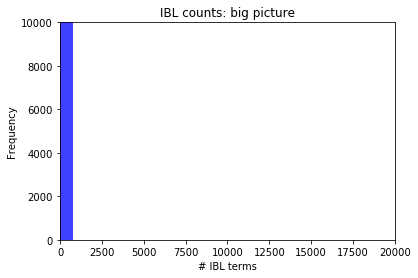

In [76]:
n, bins, patches = plt.hist(count, 50, facecolor='b', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('# IBL terms')
plt.grid(False)
plt.title('IBL counts: big picture')
plt.xlim(0, 20000)
plt.ylim(0, 10000)
plt.show()

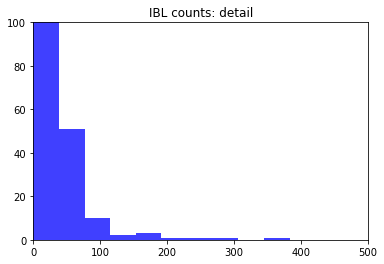

In [77]:
n, bins, patches = plt.hist(count, 1000, facecolor='b', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('# IBL terms')
plt.grid(False)
plt.title('IBL counts: detail')
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.show()

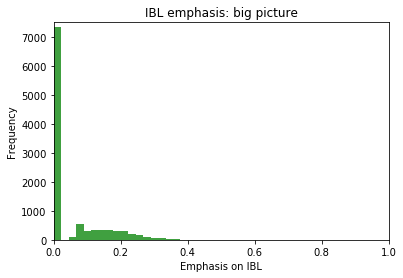

In [91]:
n, bins, patches = plt.hist(emphasis, 30, facecolor='g', alpha=0.75) # build histogram
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.title('IBL emphasis: big picture')
plt.xlim(0, 1)
plt.ylim(0, 7500)
plt.show()

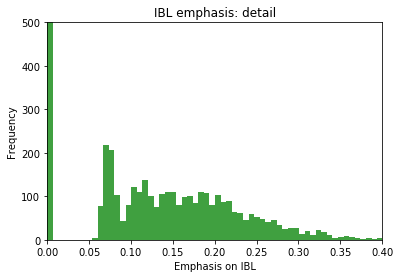

In [103]:
n, bins, patches = plt.hist(emphasis, 100, facecolor='g', alpha=0.75) # build histogram
plt.title('IBL emphasis: detail')
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.xlim(0, 0.4)
plt.ylim(0, 500)
plt.show()

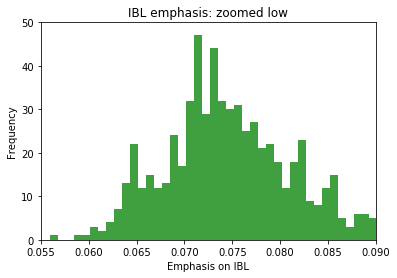

In [117]:
n, bins, patches = plt.hist(emphasis, 800, facecolor='g', alpha=0.75) # build histogram
plt.title('IBL emphasis: zoomed low')
plt.ylabel('Frequency')
plt.xlabel('Emphasis on IBL')
plt.grid(False)
plt.xlim(0.055, 0.09)
plt.ylim(0, 50)
plt.show()

## Save results

In [118]:
# Drop WEBTEXT to keep file size small:
df_new.drop(columns = "WEBTEXT", inplace=True)
list(df_new)

['NCESSCH',
 'NUMWORDS',
 'INQUIRY30_COUNT',
 'INQUIRY30_RATIO',
 'INQUIRY30_STR',
 'DISCIPLINE30_COUNT',
 'DISCIPLINE30_RATIO',
 'DISCIPLINE30_STR']

In [119]:
df_new.to_csv('../../charter_data/dict_counts/30counts_2015_250_v2a.csv')